In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.types import *
from pyspark.ml import Pipeline

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.recommendation import ALS
from pyspark.mllib.evaluation import RankingMetrics

In [2]:
spark = SparkSession.builder.appName("tsne")\
.config("spark.executor.memory", "4g")\
.config("spark.driver.memory", "4g")\
.config("spark.sql.shuffle.partitions", "50")\
.getOrCreate()

spark

In [36]:
model_25 = ALSModel.load("../models/ALS_model_rank50_reg0.1/")
item_factors = model_25.itemFactors

In [8]:
track_indexer = spark.read.parquet("../metadata/track_indexer")
track_indexer.show(2)

+-----+------------------+
|track|          track_id|
+-----+------------------+
|  224|TRTGTAG128EF353C26|
| 2367|TRLKAPQ128F92D8945|
+-----+------------------+
only showing top 2 rows



In [5]:
genre_df = spark.read.text("../metadata/msd_genre.txt")

In [6]:
track_udf = udf(lambda row: row.split("\t")[0], StringType())
genre_udf = udf(lambda row: row.split("\t")[1], StringType())

genre_df = genre_df.withColumn("track_id", track_udf(genre_df.value))\
        .withColumn("genre", genre_udf(genre_df.value))\
        .drop("value")

genre_df.show(2, truncate = False)

+------------------+-----+
|track_id          |genre|
+------------------+-----+
|TRAAAAK128F9318786|Rock |
|TRAAAAW128F429D538|Rap  |
+------------------+-----+
only showing top 2 rows



In [11]:
track_genre = track_indexer.join(genre_df, on = 'track_id', how = "inner").select("track", "genre")

track_genre = track_genre.withColumnRenamed("track", "id")
track_genre.show(2)

+------+-----+
|    id|genre|
+------+-----+
|220080|  Pop|
| 17066|  Rap|
+------+-----+
only showing top 2 rows



In [37]:
item_genres = item_factors.join(track_genre, on = 'id', how = "inner")
item_genres.show(2)

+---+--------------------+-----+
| id|            features|genre|
+---+--------------------+-----+
| 32|[0.0, 0.0, 0.0, 0...|  Pop|
| 90|[0.0, 0.0, 0.0, 0...| Punk|
+---+--------------------+-----+
only showing top 2 rows



In [38]:
latent_factors = np.array(item_genres.select("features").collect())
latent_factors = latent_factors.reshape(latent_factors.shape[0], -1)

genres = np.array([row[0] for row in item_genres.select("genre").collect()])

In [48]:
np.unique(genres, return_counts=True)

(array(['Blues', 'Country', 'Electronic', 'Folk', 'Jazz', 'Latin', 'Metal',
        'New Age', 'Pop', 'Punk', 'Rap', 'Reggae', 'RnB', 'Rock', 'World'],
       dtype='<U10'),
 array([ 2331,  4468, 13916,  2595,  7016,  1645,  6920,   683,  7480,
         2330,  7600,  4380,  4977, 50538,  1259], dtype=int64))

In [64]:
genre_filter = set(['Blues', 'Country','Folk', 'Latin', 'Metal', \
       'Punk', 'Rap', 'Reggae', 'RnB', 'World'])

use_ix = [i for (i, x) in enumerate(genres) if x in genre_filter]

In [65]:
sampled_ix = np.random.choice(use_ix, size = 10000, replace = False)
sampled_latent_factors = latent_factors[sampled_ix, :]
sampled_genres = genres[sampled_ix]

In [66]:
tsne = TSNE(verbose=1, perplexity=75)
X_embedded = tsne.fit_transform(sampled_latent_factors)

[t-SNE] Computing 226 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 2.203s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000239
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.003021
[t-SNE] KL divergence after 1000 iterations: 1.222423


<AxesSubplot:>

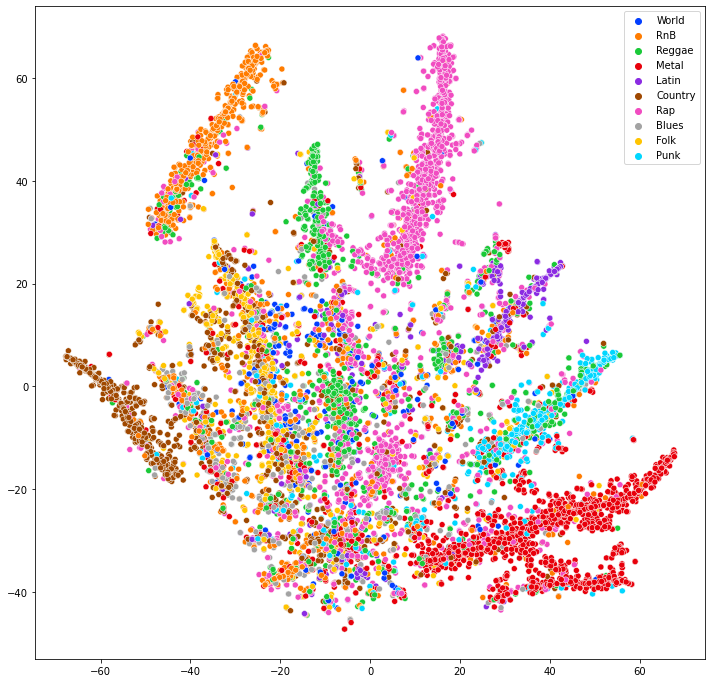

In [67]:
palette = sns.color_palette("bright", 10)
plt.figure(figsize = (12, 12))
sns.scatterplot(x = X_embedded[:,0], y = X_embedded[:,1], hue = sampled_genres, legend='full', palette=palette)